In [23]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import env, acquire, summarize, prepare

### 1. Acquire data from mall_customers in mysql database

In [4]:
mall = acquire.get_mall_data()
mall.shape

(200, 5)

In [3]:
mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


### 2. Summarize data (include distributions and descriptive statistics)

In [5]:
# Get the df having numeric variables only

mall_num = summarize.num_df(mall)
mall_num.shape

(200, 4)

In [6]:
mall_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int64(4)
memory usage: 7.8 KB


In [7]:
# Drop the customer_id col

mall_num.drop(columns=['customer_id'], inplace=True)
mall_num.shape

(200, 3)

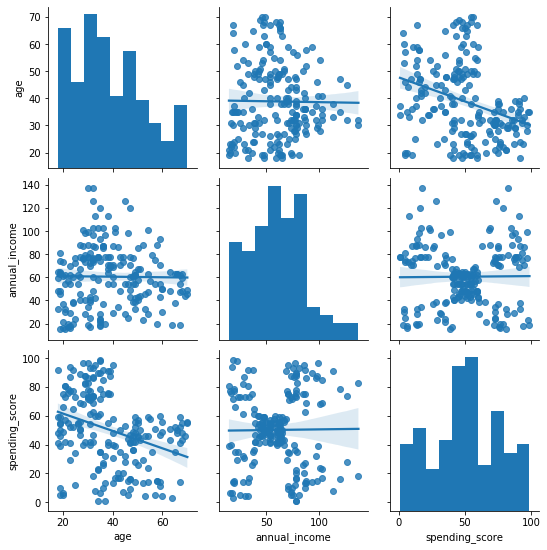

In [8]:
# Pairplot the numeric variables

summarize.plot_variable_pairs(mall_num)

In [9]:
# Get the df having object columns only

mall_obj = summarize.obj_df(mall)
mall_obj.shape

(200, 1)

In [10]:
# Display the unique values of the object cols

summarize.sum_obj_cols(mall_obj)

,dtypes,unique_values
gender,object,2


In [11]:
# Display the counts of the unique values of each object col

summarize.obj_value_counts(mall_obj)

Female    112
Male       88
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------


### 3. Detect outliers using IQR

In [ ]:
# Define the function to get_upper_outliers and add_upper_outlier_columns

def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the series.
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def upper_outlier_columns(df, k):
    '''
    Return the column(s) with the upper_outliers for all the numeric columns in the given dataframe.
    '''
    df1 = pd.DataFrame()
    for col in df.select_dtypes('number'):
        df1[col + '_upper_outliers'] = get_upper_outliers(df[col], k)
    return df1

In [12]:
# Add upper outlier cols

upper_cols = prepare.upper_outlier_columns(mall_num, 1.5)
upper_cols.shape

(200, 3)

In [ ]:
# Define the function to get_lower_outliers and add_lower_outlier_columns

def get_lower_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the series.
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    return s.apply(lambda x: min([x - lower_bound, 0]))

def lower_outlier_columns(df, k):
    '''
    Return column(s) with the lower_outliers for all the numeric columns in the given dataframe.
    '''
    df1 = pd.DataFrame()
    for col in df.select_dtypes('number'):
        df1[col + '_lower_outliers'] = get_lower_outliers(df[col], k)
    return df1

In [13]:
# Add lower outlier cols

lower_cols = prepare.lower_outlier_columns(mall_num, 1.5)
lower_cols.shape

(200, 3)

In [14]:
# Join mall with outlier cols

mall_outliers = pd.concat([mall, upper_cols, lower_cols], axis=1)
mall_outliers.shape

(200, 11)

In [15]:
mall_outliers.tail()

,customer_id,gender,age,annual_income,spending_score,age_upper_outliers,annual_income_upper_outliers,spending_score_upper_outliers,age_lower_outliers,annual_income_lower_outliers,spending_score_lower_outliers
195,196,Female,35,120,79,0,0.00,0,0,0,0
196,197,Female,45,126,28,0,0.00,0,0,0,0
197,198,Male,32,126,74,0,0.00,0,0,0,0
198,199,Male,32,137,18,0,4.25,0,0,0,0
199,200,Male,30,137,83,0,4.25,0,0,0,0


In [16]:
# Summarize Outliers

outlier_cols = [col for col in mall_outliers if col.endswith('_outliers')]
(mall_outliers[outlier_cols] != 0).sum(axis=0)

age_upper_outliers               0
annual_income_upper_outliers     2
spending_score_upper_outliers    0
age_lower_outliers               0
annual_income_lower_outliers     0
spending_score_lower_outliers    0
dtype: int64

### 4. Splite data (train, validate, and split)

In [7]:
train, validate, test = prepare.split_my_data(mall, pct=0.15)

train.shape, validate.shape, test.shape

((119, 5), (51, 5), (30, 5))

### 5. Encode categorical columns using a one hot encoder.

In [8]:
def encode_label(df, columns_to_encode):
    """
    Dummy coding of categorical varibales
    Parameters: df, columns_to_encode(list)
    """
    obj_df = df[columns_to_encode]
    dummy_df = pd.get_dummies(obj_df, dummy_na=False, drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(columns=columns_to_encode, inplace=True)
    return df

In [9]:
train.head()

,customer_id,gender,age,annual_income,spending_score
89,90,Female,50,58,46
62,63,Female,67,47,52
151,152,Male,39,78,88
79,80,Female,49,54,42
122,123,Female,40,69,58


In [11]:
train = encode_label(train, ['gender'])
validate = encode_label(validate, ['gender'])
test = encode_label(test, ['gender'])

train.shape, validate.shape, test.shape

((119, 5), (51, 5), (30, 5))

In [12]:
train.head()

,customer_id,age,annual_income,spending_score,gender_Male
89,90,50,58,46,0
62,63,67,47,52,0
151,152,39,78,88,1
79,80,49,54,42,0
122,123,40,69,58,0


### 6. Handles missing values.
- No missing values have been found.

In [13]:
train.isna().sum(axis=0)

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

In [14]:
validate.isna().sum(axis=0)

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

In [15]:
test.isna().sum(axis=0)

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

### 7. Scaling

In [16]:
train.columns

Index(['customer_id', 'age', 'annual_income', 'spending_score', 'gender_Male'], dtype='object')

In [26]:
def scale(train, validate, test, columns_to_scale):
    """
    Scale the columns using MinMaxScaler
    Parameters: train(df), validate(df), test(df), columns_to_scale(list)
    """
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test

In [27]:
columns_to_scale = ['age', 'annual_income', 'gender_Male']
train, validate, test = scale(train, validate, test, columns_to_scale)

train.shape, validate.shape, test.shape

((119, 8), (51, 8), (30, 8))

In [28]:
train.head()

,customer_id,age,annual_income,spending_score,gender_Male,age_scaled,annual_income_scaled,gender_Male_scaled
89,90,50,58,46,0,0.615385,0.352459,0.0
62,63,67,47,52,0,0.942308,0.262295,0.0
151,152,39,78,88,1,0.403846,0.516393,1.0
79,80,49,54,42,0,0.596154,0.319672,0.0
122,123,40,69,58,0,0.423077,0.442623,0.0
